In [ ]:
!pip install ase
!pip install hist
!pip install lmfit
!pip install xraylib

In [8]:
from ase.data import atomic_numbers
import ase.units as units

import glob

import json

import hist

from lmfit import Parameters
from lmfit.models import PolynomialModel, GaussianModel, ExponentialModel, PowerLawModel, RectangleModel

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

import numpy as np

import os

import pandas as pd

import re

from scipy.signal import find_peaks

from uncertainties import unumpy as unp

import xraylib


def load_mca_file(mcafile, rebin=1):

    df = pd.read_csv(mcafile, encoding='cp1252')
    
    counts = []
    save_data = False

    for row in df.to_numpy():
        if row[0] == '<<END>>':
            save_data = False
        if save_data:
            counts.append(float(row[0]))
        if row[0] == '<<DATA>>':
            save_data = True

    counts = np.array(counts, dtype=int)    
    bins = np.arange(8193)
    
    histogram = hist.Hist(
        hist.axis.Variable(bins, name="Ch", label="Channels"),
        storage=hist.storage.Weight(),
    )

    bin_centers = histogram.axes[0].centers

    for center, count in zip(bin_centers, counts):
        histogram.fill(np.full(count, center))

    return histogram[::hist.rebin(rebin)]

Text(0, 0.5, 'Conteggi / 8 Canali')

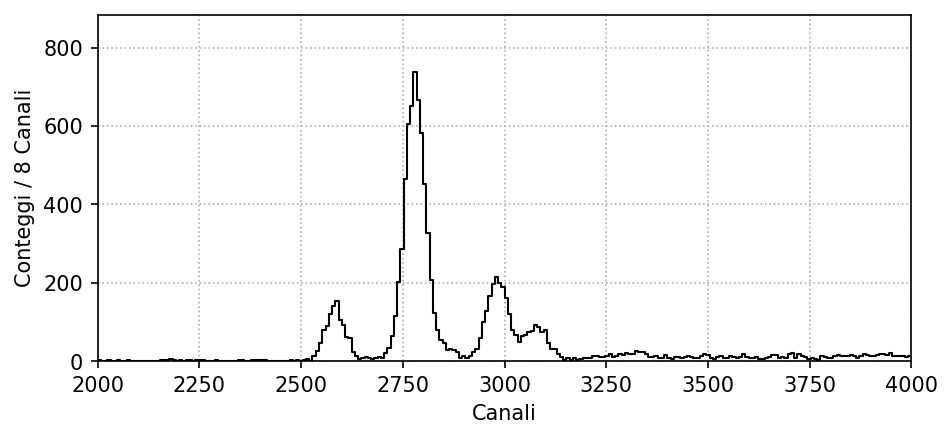

In [77]:
rebin = 8
histogram = load_mca_file('2024_11_04_V20_I300_T100_CuNiZn.mca', rebin=rebin)

fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers = histogram.axes[0].centers
counts = histogram.values()

ax.step(centers, counts, where='mid', c='k', lw=1)

ax.set_xlim(0,8192)
ax.set_xlim(2e3,4e3)
ax.set_ylim(0,counts.max()*1.2)
ax.set_xlabel('Canali')
ax.set_ylabel(f'Conteggi / {rebin} Canali')

In [78]:
params = Parameters()

params.add('c0', value=1)
params.add('c1', value=1)
params.add('NiKa_amplitude', value=1e4, min=0)
params.add('NiKa_center', value=2580)
params.add('NiKa_sigma', value=30, min=1, max=100)
params.add('NiKb_amplitude', value=1e4, min=0)
params.add('NiKb_center', value=2880, min=2850, max=2900)
params.add('NiKb_sigma', value=30, min=1, max=100)
params.add('CuKa_amplitude', value=1e4, min=0)
params.add('CuKa_center', value=2780)
params.add('CuKa_sigma', value=30, min=1, max=100)
params.add('CuKb_amplitude', value=1e4, min=0)
params.add('CuKb_center', value=3080, min=3000)
params.add('CuKb_sigma', value=30, min=1, max=100)
params.add('ZnKa_amplitude', value=1e4, min=0)
params.add('ZnKa_center', value=2980, min=2950, max=3000)
params.add('ZnKa_sigma', value=30, min=1, max=50)
params.add('ZnKb_amplitude', value=1e4, min=0)
params.add('ZnKb_center', value=3300, min=3250, max=3350)
params.add('ZnKb_sigma', value=30, min=1, max=50)

model = PolynomialModel(degree=1)
model += GaussianModel(prefix='NiKa_')
model += GaussianModel(prefix='NiKb_')
model += GaussianModel(prefix='CuKa_')
model += GaussianModel(prefix='CuKb_')
model += GaussianModel(prefix='ZnKa_')
model += GaussianModel(prefix='ZnKb_')

ind = np.where(counts > 0)[0]
x = centers[ind]
y = counts[ind]


result = model.fit(y, params, x=x, weights=1/np.sqrt(y))
print(result.fit_report(show_correl=False))

[[Model]]
    ((((((Model(polynomial) + Model(gaussian, prefix='NiKa_')) + Model(gaussian, prefix='NiKb_')) + Model(gaussian, prefix='CuKa_')) + Model(gaussian, prefix='CuKb_')) + Model(gaussian, prefix='ZnKa_')) + Model(gaussian, prefix='ZnKb_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 260
    # data points      = 595
    # variables        = 20
    chi-square         = 2553.69006
    reduced chi-square = 4.44120011
    Akaike info crit   = 906.756296
    Bayesian info crit = 994.527524
    R-squared          = 0.99914935
[[Variables]]
    c0:              1.52317808 +/- 0.35617892 (23.38%) (init = 1)
    c1:              6.2457e-04 +/- 8.3581e-05 (13.38%) (init = 1)
    NiKa_amplitude:  7548.39920 +/- 535.366034 (7.09%) (init = 10000)
    NiKa_center:     2584.68557 +/- 1.62457941 (0.06%) (init = 2580)
    NiKa_sigma:      21.4353200 +/- 1.20191259 (5.61%) (init = 30)
    NiKb_amplitude:  1445.73287 +/- 575.839510 (39.83%) (init = 10000)
    NiKb_

Text(0, 0.5, 'Conteggi / 8 Canali')

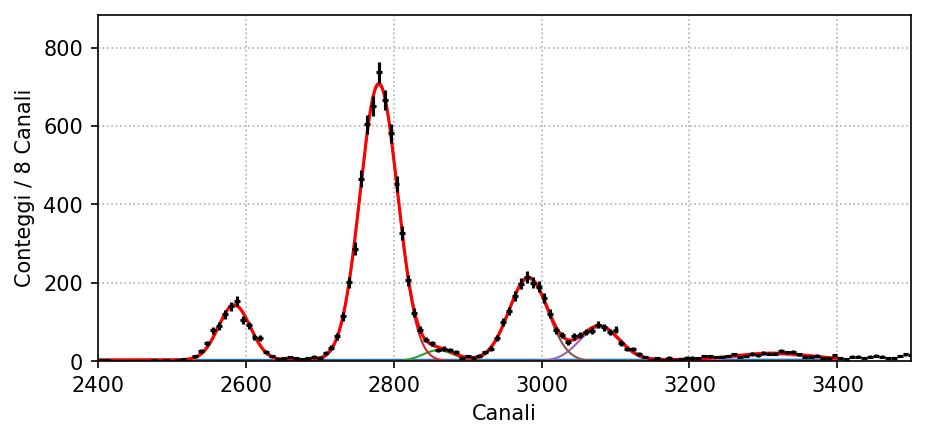

In [ ]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers = histogram.axes[0].centers
counts = histogram.values()

x_i = np.linspace(2400,3400, 1000)
fit_i = model.eval(result.params, x=x_i)

components = result.eval_components(x=x_i)

for key in components.keys():
    ax.plot(x_i, components[key], lw=1)

ax.plot(x_i, fit_i, c='r')
# ax.step(centers, counts, where='mid', c='k', lw=1)
ax.errorbar(centers, counts, np.sqrt(counts), rebin/2, fmt=' ', c='k', lw=1.5, ms=1.5, capsize=0)

ax.set_xlim(2400,3500)
ax.set_ylim(0,1.2e3)
# ax.set_ylim(2,1e3)#counts.max()*1.2)
ax.set_ylim(0,counts.max()*1.2)
ax.set_xlabel('Canali')
ax.set_ylabel(f'Conteggi / {rebin} Canali')

In [107]:
params = result.params

canali = [param.value for param in params.values() if 'Ka_center' in param.name]
err_canali = [param.stderr for param in params.values() if 'Ka_center' in param.name]



In [116]:
ref_energies = []

ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Ni'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Cu'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Zn'), xraylib.KA_LINE) * 1e3)

energies

[7472.2769470121975, 8041.05061567418, 8631.0590577321]

<ErrorbarContainer object of 3 artists>

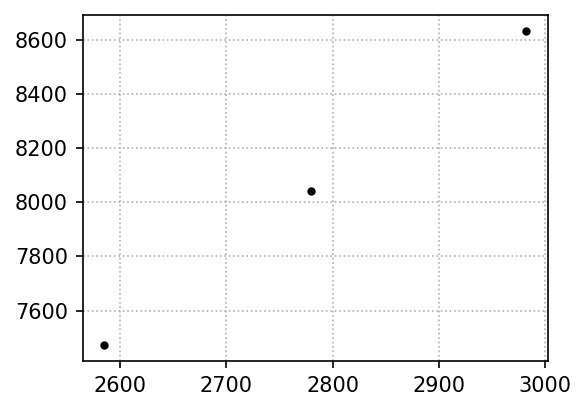

In [138]:
fig, ax = plt.subplots(figsize=(4,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")

ax.errorbar(canali, ref_energies, err_canali, fmt='o', c='k', lw=1, ms=3)

In [126]:
params = Parameters()

params.add('c0', value=1)
params.add('c1', value=1)

model = PolynomialModel(degree=1)

x = canali
y = ref_energies

result = model.fit(y, params, x=x)
print(result.fit_report(show_correl=False))

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 3
    # variables        = 2
    chi-square         = 0.38471520
    reduced chi-square = 0.38471520
    Akaike info crit   = -2.16159273
    Bayesian info crit = -3.96436816
    R-squared          = 0.99999943
[[Variables]]
    c0: -60.6178668 +/- 6.14823373 (10.14%) (init = 1)
    c1:  2.91433410 +/- 0.00220596 (0.08%) (init = 1)


(2500.0, 3100.0)

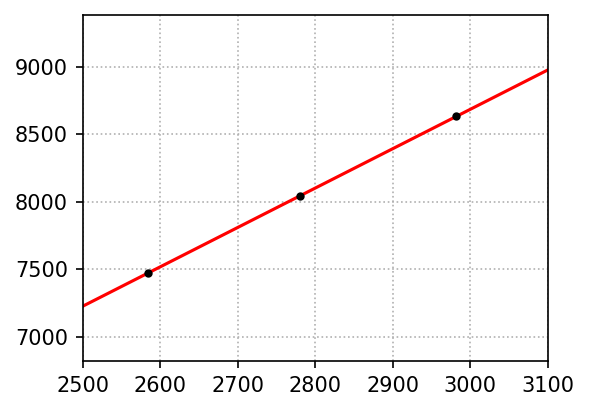

In [140]:
fig, ax = plt.subplots(figsize=(4,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")

ax.errorbar(canali, ref_energies, err_canali, fmt='o', c='k', lw=1, ms=3)

x_i = np.linspace(2400,3200, 1000)
fit_i = model.eval(result.params, x=x_i)

ax.plot(x_i, fit_i, c='r')

ax.set_xlim(2500,3100)


Text(0, 0.5, 'Conteggi / 8 Canali')

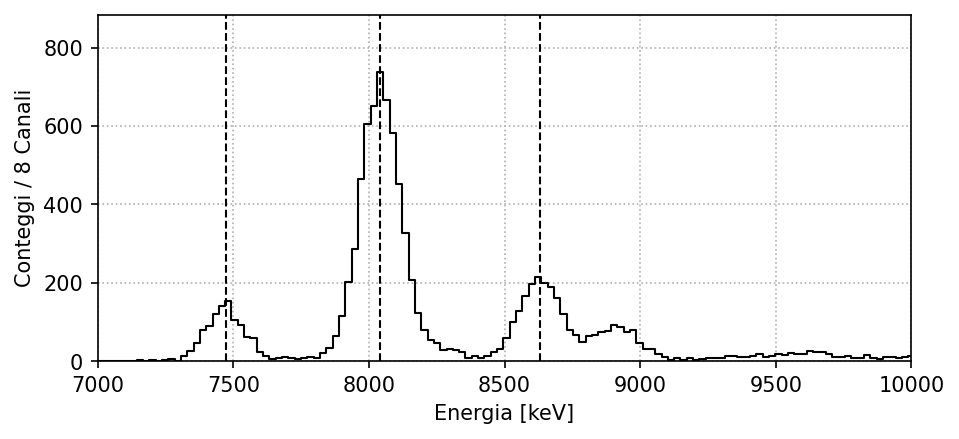

In [135]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

offset = result.params['c0'].value
gain = result.params['c1'].value

energies = gain * centers + offset 

ax.axvline(ref_energies[0], c='k', lw=1, ls='--')
ax.axvline(ref_energies[1], c='k', lw=1, ls='--')
ax.axvline(ref_energies[2], c='k', lw=1, ls='--')

ax.step(energies, counts, where='mid', c='k', lw=1)

# ax.set_xlim(0,8192)
ax.set_xlim(7e3,10e3)
ax.set_ylim(0,counts.max()*1.2)
ax.set_xlabel('Energia [keV]')
ax.set_ylabel(f'Conteggi / {rebin} Canali')
